## Dataset Overview

In [ ]:
import pandas as pd

imgs  = pd.read_csv("data/img.csv")    
annos = pd.read_csv("data/annot.csv")  

annos = annos.merge(
    imgs[["id","file_name"]],
    left_on="image_id",
    right_on="id",
    how="inner"
)

annos = annos.dropna(subset=["utf8_string"])
annos["utf8_string"] = annos["utf8_string"].astype(str)

page_texts = (
    annos
    .groupby("file_name")["utf8_string"]
    .apply(lambda ws: " ".join(ws))
    .reset_index(name="text")
)

print(page_texts.head())
print("Built text for", len(page_texts), "images.")


                    file_name  \
0  train/0000e8b36676338b.jpg   
1  train/00010bf498b64bab.jpg   
2  train/00016982f6086d39.jpg   
3  train/0001c6bf48e16ab2.jpg   
4  train/000209d575f3aa4f.jpg   

                                                text  
0                             FELIX PRIVAT DBU 889 .  
1  TEQU A KOLA 28 MZ 2387 . AMS . . . . . . . . ....  
2  3G Applications 12:15 LightSabre ScreenSnap Ad...  
3        NISSAN GENISS . NISSAN LIVINA GENISS NISSAN  
4  . BEER. MACAU MACAU BEER MACAU BEER . . . . . ...  
Built text for 21778 images.


In [ ]:
import os

tess_path = r"C:\Users\ga.aldaej\AppData\Local\Programs\Tesseract-OCR"
os.environ["PATH"] = tess_path + os.pathsep + os.environ["PATH"]

import pytesseract
pytesseract.pytesseract.tesseract_cmd = tess_path + r"\tesseract.exe"


In [ ]:
import pandas as pd

overview = (
    imgs
    .rename(columns={"file_name":"filename"})
    .merge(page_texts.rename(columns={"file_name":"filename"}),
           on="filename", how="inner")
)
print(f"Overview DF has {len(overview)} rows (images with text).")
overview.head()


Overview DF has 21778 rows (images with text).


Unnamed: 0                id  width  height    set  \
0           0  a4ea732cd3d5948a    840    1024  train   
1           1  4bf43a7b2a898044   1024     683  train   
2           2  1b55b309b0f50d02   1024     683  train   
3           3  00c359f294f7dcd9   1024     680  train   
4           4  04b5a37f762b0f51    768    1024  train   

                     filename  \
0  train/a4ea732cd3d5948a.jpg   
1  train/4bf43a7b2a898044.jpg   
2  train/1b55b309b0f50d02.jpg   
3  train/00c359f294f7dcd9.jpg   
4  train/04b5a37f762b0f51.jpg   

                                                text  
0  Performance Sport Watch ...period. . 400 300 1...  
1  400 Z 7 at nLa A. James LYNCH REAL ESTATE 781....  
2  CAOL ILA DISTILLERY 1996 GLE MALT SCOTCH WHISK...  
3                                     G-ATCO HUSKY +  
4  OUR NEIGHBORS, THE FRIENDS . . . 1 Muhomah . f...

In [ ]:
print(" Type of text: Printed, natural scene text (street signs, packaging, documents)\n")

num_images = len(overview)
print(f"Number of images: {num_images}\n")

# Image formats
format_counts = overview["filename"].str.split(".").str[-1].value_counts()
print(" Image formats:\n", format_counts.to_dict(), "\n")


 Type of text: Printed, natural scene text (street signs, packaging, documents)

Number of images: 21778

 Image formats:
 {'jpg': 21778} 



In [ ]:
res_counts = (
    overview
    .groupby(["width","height"])
    .size()
    .sort_values(ascending=False)
    .head(5)
)
print(" Top 5 resolutions (w×h → count):\n")
for (w,h),cnt in res_counts.items():
    print(f"   {w}×{h} → {cnt}")


 Top 5 resolutions (w×h → count):

   1024×768 → 5373
   1024×683 → 2395
   768×1024 → 1644
   1024×1024 → 1506
   1024×680 → 657


 Word‐count summary:
count    21778.000000
mean        48.318395
std         91.258588
min          1.000000
25%          9.000000
50%         21.000000
75%         49.000000
max       2337.000000
Name: word_count, dtype: float64 



<Axes: >

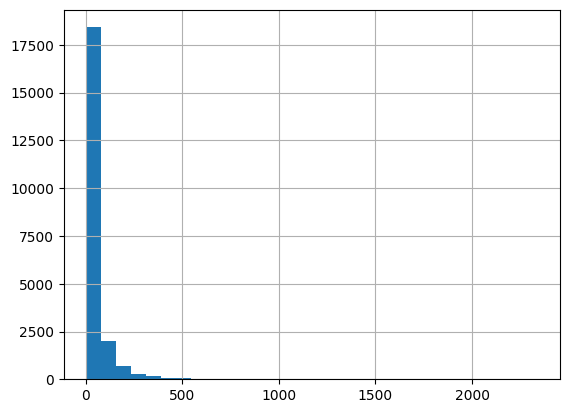

In [ ]:
overview["word_count"] = overview["text"].str.split().str.len()

print(" Word‐count summary:")
print(overview["word_count"].describe(), "\n")

# Simple histogram
overview["word_count"].hist(bins=30)


In [ ]:
import numpy as np
import cv2
from PIL import Image
from pathlib import Path

IMG_DIR = Path("data/train_val_images")

def compute_qc(fn):
    p = IMG_DIR / fn
    if not p.exists():
        matches = list(IMG_DIR.rglob(Path(fn).name))
        if not matches:
            raise FileNotFoundError(f"Couldn't find {fn} under {IMG_DIR}")
        p = matches[0]
    im = np.array(Image.open(p).convert("L"), dtype=np.float32)
    contrast = im.std()
    blur     = cv2.GaussianBlur(im, (5,5), 0)
    noise    = np.std(im - blur)
    return contrast, noise

sample = overview.sample(1000, random_state=0).copy()

qc = sample["filename"].apply(compute_qc)
sample[["contrast","noise"]] = pd.DataFrame(qc.tolist(), index=sample.index)

print(sample[["contrast","noise"]].describe())


          contrast        noise
count  1000.000000  1000.000000
mean     61.217686     6.875976
std      15.473701     3.854536
min      14.431637     0.481921
25%      50.881097     4.091184
50%      61.138397     6.106231
75%      71.353401     8.574534
max     115.174110    33.174759


## Image Preprocessing

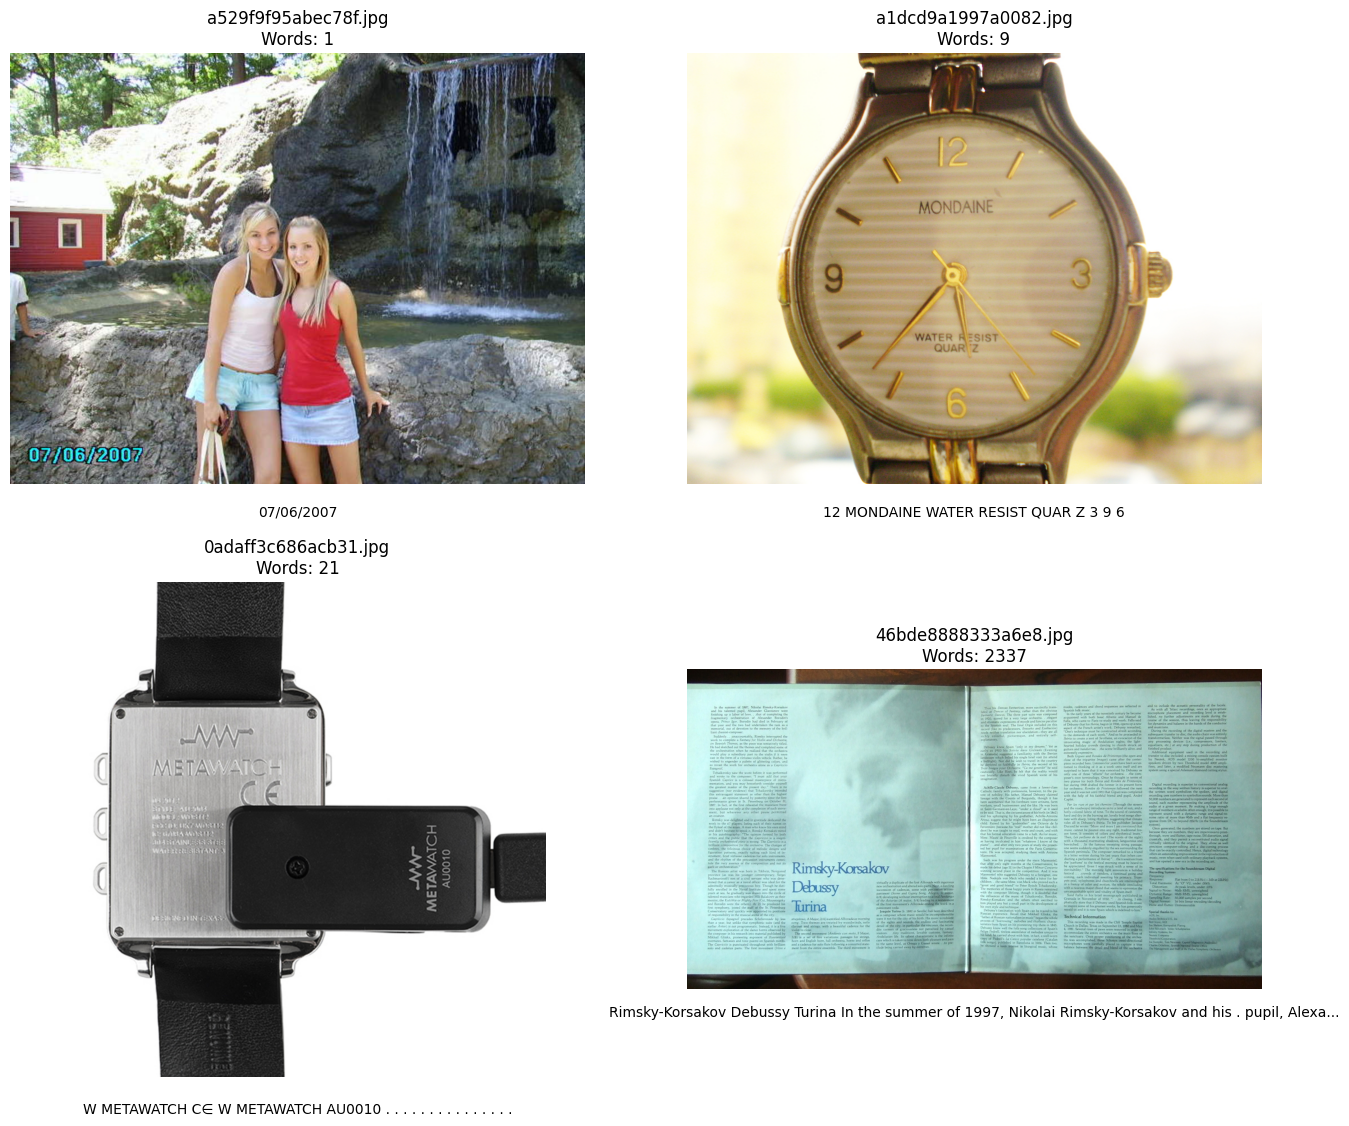

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from pathlib import Path

imgs  = pd.read_csv("data/img.csv")      
annos = pd.read_csv("data/annot.csv")    

annos = (
    annos
    .merge(imgs[["id","file_name"]], left_on="image_id", right_on="id", how="inner")
    .dropna(subset=["utf8_string"])
)
annos["utf8_string"] = annos["utf8_string"].astype(str)

page_texts = (
    annos
    .groupby("file_name")["utf8_string"]
    .apply(lambda ws: " ".join(ws))
    .reset_index(name="text")
)

overview = (
    imgs.rename(columns={"file_name":"filename"})
    .merge(page_texts.rename(columns={"file_name":"filename"}), on="filename", how="inner")
)
overview["word_count"] = overview["text"].str.split().str.len()

sorted_over = overview.sort_values("word_count").reset_index(drop=True)
n = len(sorted_over)
examples = [
    sorted_over.iloc[0],      # fewest words
    sorted_over.iloc[n//4],   # 25th percentile
    sorted_over.iloc[n//2],   # median
    sorted_over.iloc[-1]      # most words
]

IMG_DIR   = Path("data/train_val_images")
TRAIN_SUB = IMG_DIR / "train_images"
VAL_SUB   = IMG_DIR / "val_images"

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, row in zip(axes, examples):
    fn  = row["filename"]      
    txt = row["text"]
    wc  = row["word_count"]

    # locate the image
    img_path = IMG_DIR / fn
    if not img_path.exists() and fn.startswith("train/"):
        img_path = TRAIN_SUB / Path(fn).name
    if not img_path.exists() and fn.startswith("val/"):
        img_path = VAL_SUB / Path(fn).name
    if not img_path.exists():
        matches = list(IMG_DIR.rglob(Path(fn).name))
        if matches:
            img_path = matches[0]
    if not img_path.exists():
        raise FileNotFoundError(f"Couldn't find image for {fn}")

    # display the image
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")

    ax.set_title(f"{Path(fn).name}\nWords: {wc}", fontsize=12)

    snippet = txt.replace("\n", " ")
    snippet = (snippet[:100] + "...") if len(snippet) > 100 else snippet
    ax.text(
        0.5, -0.05,
        snippet,
        transform=ax.transAxes,
        ha="center", va="top",
        wrap=True, fontsize=10
    )

plt.tight_layout(rect=[0,0.05,1,1])
plt.show()


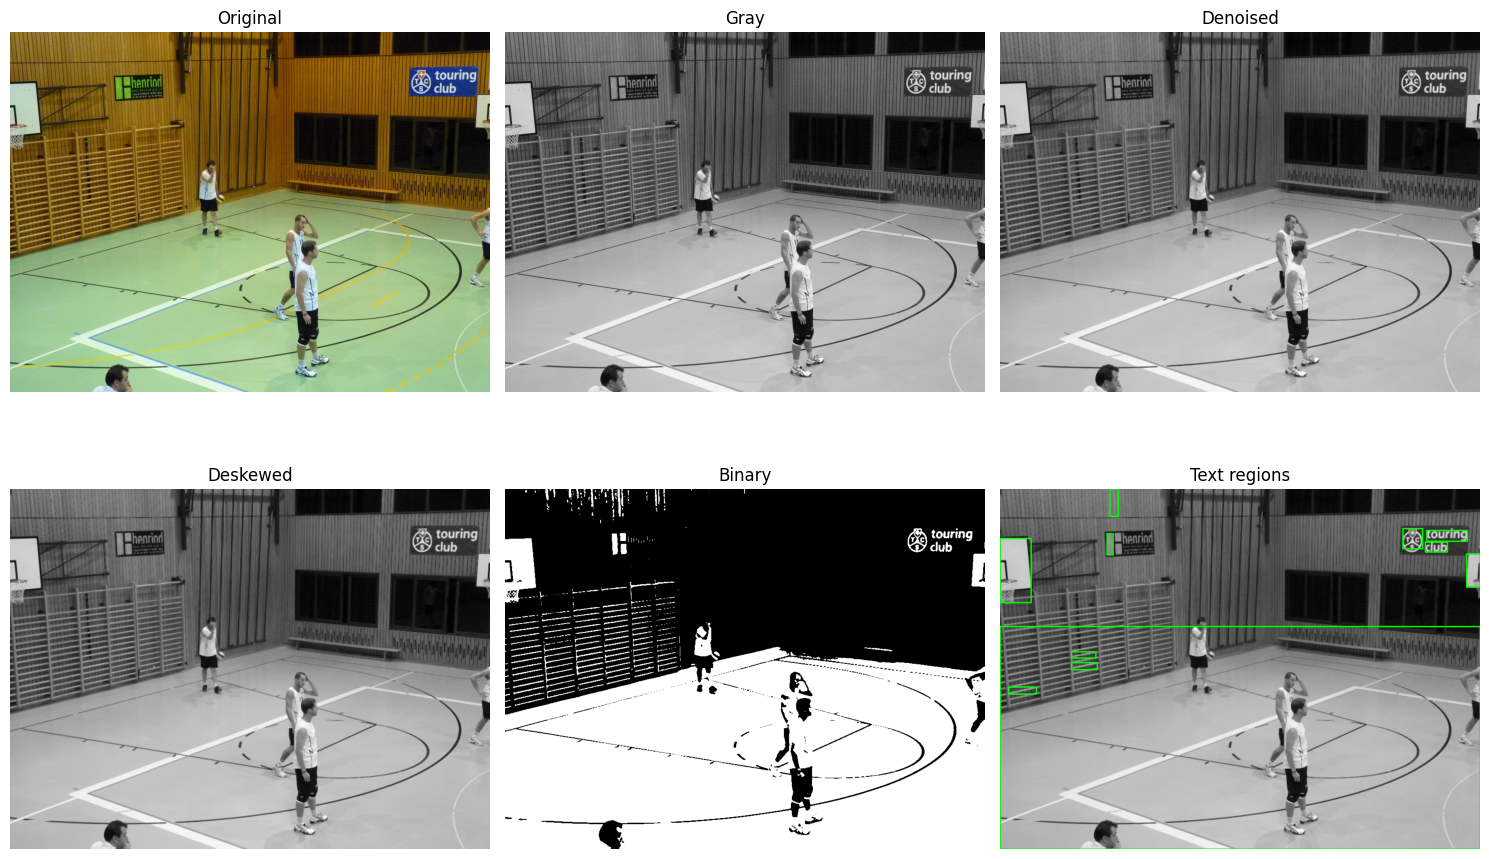

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

def preprocess_and_clean(path):
    img      = cv2.imread(str(path))
    gray     = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    denoised = cv2.medianBlur(gray, 3)
    edges    = cv2.Canny(denoised, 50, 150)
    lines    = cv2.HoughLines(edges, 1, np.pi/180, 200)
    angle    = 0.0
    if lines is not None:
        angles = [theta - np.pi/2 for [[_, theta]] in lines[:20]]
        angle  = float(np.median(angles))
    h, w     = denoised.shape
    M        = cv2.getRotationMatrix2D((w//2, h//2), angle*180/np.pi, 1.0)
    deskewed = cv2.warpAffine(denoised, M, (w, h),
                              flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_REPLICATE)
    _, binary = cv2.threshold(deskewed, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    k         = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opened    = cv2.morphologyEx(binary, cv2.MORPH_OPEN,  k)
    cleaned   = cv2.morphologyEx(opened,  cv2.MORPH_CLOSE, k)
    return img, gray, denoised, deskewed, binary, cleaned

def detect_text_regions(mask, min_area=500):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes   = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w*h > min_area:
            boxes.append((x, y, w, h))
    return boxes

# Visualize on a random image
IMG_DIR = Path("data/train_val_images/train_images")
sample  = random.choice(list(IMG_DIR.glob("*.jpg")))

orig, gray, denoised, deskewed, binary, cleaned = preprocess_and_clean(sample)
boxes = detect_text_regions(cleaned)

fig, axs = plt.subplots(2, 3, figsize=(15,10))
titles = ["Original","Gray","Denoised","Deskewed","Binary","Cleaned"]
imgs   = [
    cv2.cvtColor(orig, cv2.COLOR_BGR2RGB),
    gray, denoised, deskewed, binary, cleaned
]

for ax, im, t in zip(axs.flatten(), imgs, titles):
    ax.imshow(im, cmap="gray" if im.ndim==2 else None)
    ax.set_title(t)
    ax.axis("off")

vis = cv2.cvtColor(deskewed, cv2.COLOR_GRAY2RGB)
for x,y,w,h in boxes:
    cv2.rectangle(vis, (x,y), (x+w,y+h), (0,255,0), 2)
axs[1,2].imshow(vis)
axs[1,2].set_title("Text regions")
axs[1,2].axis("off")

plt.tight_layout()
plt.show()


## 3 OCR Engine Integration

In [10]:
import os
import cv2
import matplotlib.pyplot as plt
import easyocr


In [ ]:
reader = easyocr.Reader(['en'])  


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


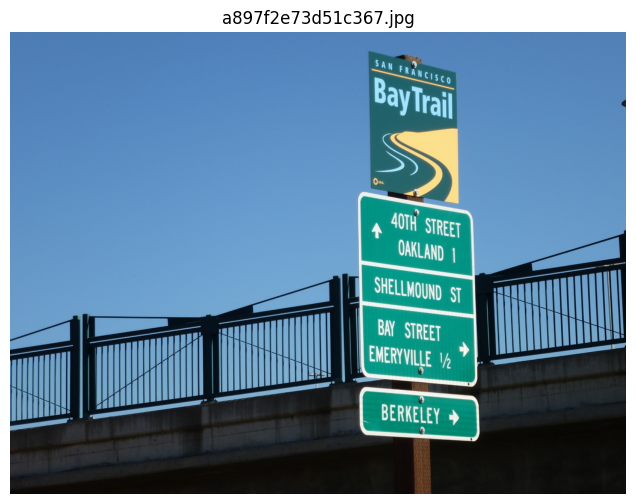

In [13]:
# Folder path
folder_path = 'data/train_val_images/train_images'

# Get all image filenames
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]

# Randomly pick one
random_image = random.choice(image_files)
image_path = os.path.join(folder_path, random_image)

# Load and convert image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show original image
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.title(random_image)
plt.axis('off')
plt.show()


## Run OCR model on one photo to see the result

c:\Users\ga.aldaej\AppData\Local\anaconda3\envs\task6_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


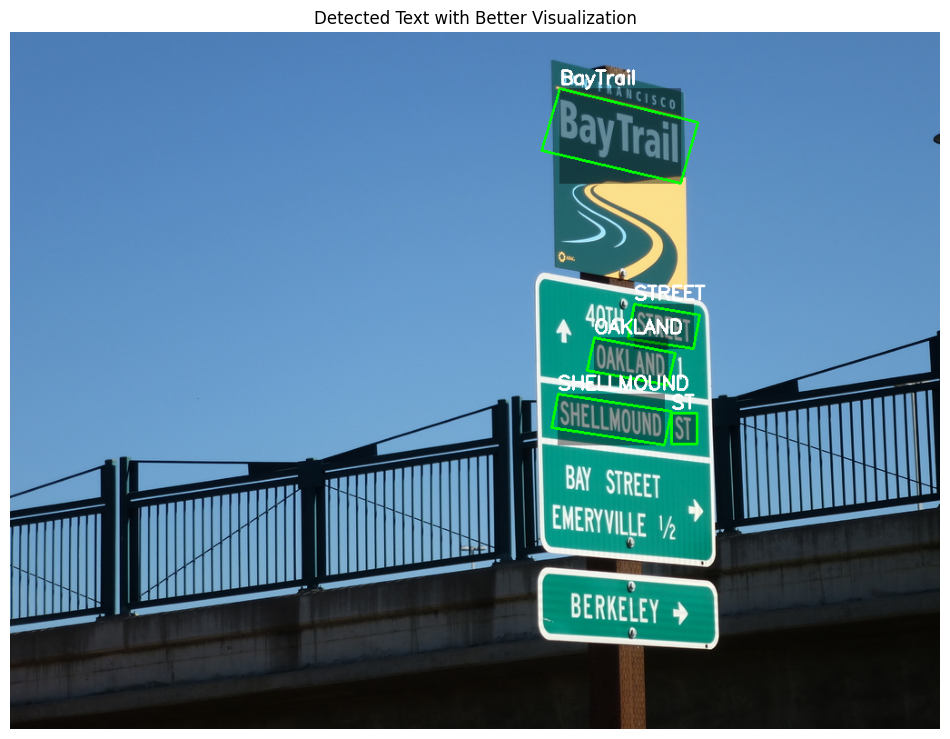

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Run EasyOCR on the selected image
ocr_results = reader.readtext(image_path)

# Copy image for annotation
image_with_boxes = image_rgb.copy()

# Draw OCR results
for result in ocr_results:
    bbox, text, confidence = result
    if confidence < 0.5:  # Skip low-confidence detections
        continue

    pts = np.array(bbox).astype(int)
    top_left = tuple(pts[0])
    bottom_right = tuple(pts[2])

    # Draw semi-transparent background
    overlay = image_with_boxes.copy()
    cv2.rectangle(overlay, top_left, bottom_right, (0, 0, 0), -1)  # black background
    image_with_boxes = cv2.addWeighted(overlay, 0.4, image_with_boxes, 0.6, 0)

    # Draw polygon border (green)
    cv2.polylines(image_with_boxes, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

    # Put detected text (white on black)
    cv2.putText(image_with_boxes, text, (top_left[0], top_left[1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Show the result
plt.figure(figsize=(12, 10))
plt.imshow(image_with_boxes)
plt.title("Detected Text with Better Visualization")
plt.axis("off")
plt.show()


## Run ocr (easyocr) on 1000 images 

In [ ]:
import os
import random
import easyocr
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

original_dir  = "data/train_val_images/train_images"
output_csv    = "csv_output/extracted_text.csv"
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
NUM_SAMPLES = 1000
all_files = [
    f for f in os.listdir(original_dir)
    if f.lower().endswith((".jpg","jpeg",".png"))
]

sampled_files = random.sample(all_files, min(NUM_SAMPLES, len(all_files)))
reader = easyocr.Reader(['en', 'ar'], gpu=True)

def process_image(image_file):
    image_path = os.path.join(original_dir, image_file)
    try:
        results = reader.readtext(image_path)
        texts = []
        confidences = []
        for bbox, text, confidence in results:
            if confidence >= 0.5:
                texts.append(text.strip())
                confidences.append(confidence)

        full_text   = "\n".join(texts)
        avg_conf    = round(sum(confidences)/len(confidences), 3) if confidences else 0.0
        line_count  = len(texts)
        return [image_file, full_text, avg_conf, line_count]

    except Exception as e:
        return [image_file, "", 0.0, 0]

results = []
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = {executor.submit(process_image, fname): fname for fname in sampled_files}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Extracting text"):
        results.append(future.result())


df = pd.DataFrame(
    results,
    columns=["image_name", "extracted_text", "avg_confidence", "line_count"]
)
os.makedirs(os.path.dirname(output_csv), exist_ok=True)
df.to_csv(output_csv, index=False, encoding="utf-8-sig")

print(f"\nDone! OCR results for {len(sampled_files)} images saved to:\n  {output_csv}")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Extracting text:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\ga.aldaej\AppData\Local\anaconda3\envs\task6_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Extracting text:   0%|          | 1/1000 [00:35<9:45:58, 35.19s/it]c:\Users\ga.aldaej\AppData\Local\anaconda3\envs\task6_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ga.aldaej\AppData\Local\anaconda3\envs\task6_env\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
E

## post processing

In [ ]:
import re
import unicodedata
import pandas as pd
from spellchecker import SpellChecker

df = pd.read_csv("csv_output/extracted_text.csv", encoding="utf-8-sig")

def clean_ocr_text(text):
    if not isinstance(text, str):
        text = ""
    text = unicodedata.normalize("NFKC", text)
    text = text.replace("\n", " ").replace("\t", " ")
    text = re.sub(r"[^\w\s\u0600-\u06FF.,!?;:()\"'\-]", "", text)
    text = re.sub(r"([.,!?؛،]){2,}", r"\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[A-Z]", lambda m: m.group().lower(), text)
    return text

df["cleaned_text"] = df["extracted_text"].fillna("").apply(clean_ocr_text)

spell = SpellChecker()

def correct_spelling(text):
    if not isinstance(text, str):
        return ""
    words = text.split()
    out = []
    for w in words:
        if not w:
            continue
        if w.isalpha():
            corr = spell.correction(w)
            out.append(corr if isinstance(corr, str) else w)
        else:
            out.append(w)
    return " ".join(out)

df["final_text"] = df["cleaned_text"].fillna("").apply(correct_spelling)

# Save post-processed CSV
df.to_csv(
    "csv_output/final_extracted_text.csv",
    columns=["image_name","final_text","avg_confidence","line_count"],
    index=False,
    encoding="utf-8-sig"
)
print(" Post-processed OCR saved to csv_output/final_extracted_text.csv")


 Post-processed OCR saved to csv_output/final_extracted_text.csv


## Evaluation


In [ ]:
import json
import pandas as pd
from jiwer import cer, wer

# Load final OCR output
df = pd.read_csv("csv_output/final_extracted_text.csv", encoding="utf-8-sig")

annos = pd.read_csv("data/annot.csv").dropna(subset=["utf8_string"])
imgs  = pd.read_csv("data/img.csv")[["id","file_name"]]
gold = (
    annos
    .merge(imgs, left_on="image_id", right_on="id")
    .groupby("file_name")["utf8_string"]
    .apply(lambda ws: " ".join(ws))
    .rename("gold_text")
)

#  Join and fill missing
df = df.set_index("image_name").join(gold).reset_index()
df["gold_text"]  = df["gold_text"].fillna("") 
df["final_text"] = df["final_text"].fillna("")


# Compute CER & WER
df["CER"] = df.apply(lambda r: cer(r["gold_text"], r["final_text"]), axis=1)
df["WER"] = df.apply(lambda r: wer(r["gold_text"], r["final_text"]), axis=1)

# 6) Print summary
print(f" Mean CER: {df['CER'].mean():.3f}")
print(f" Mean WER: {df['WER'].mean():.3f}\n")

print(" Best 3 pages (lowest WER):")
print(df.nsmallest(3, "WER")[["image_name","WER","final_text"]], "\n")

print(" Worst 3 pages (highest WER):")
print(df.nlargest(3, "WER")[["image_name","WER","final_text"]])


 Mean CER: 30.774
 Mean WER: 5.722

 Best 3 pages (lowest WER):
             image_name  WER final_text
3  2e2c799ddb208156.jpg    0           
4  838c5672e7a5e4ed.jpg    0           
5  8bc43562bc0be95c.jpg    0            

 Worst 3 pages (highest WER):
               image_name  WER  \
997  4625b91150946824.jpg  254   
818  9a72dc642a655070.jpg  236   
454  fb62ffd8f378c98a.jpg  210   

                                            final_text  
997  come to she seemed so full certainly character...  
818  distinction between instrumental and therapeut...  
454  teen her childhood here her folk chronicler an...  


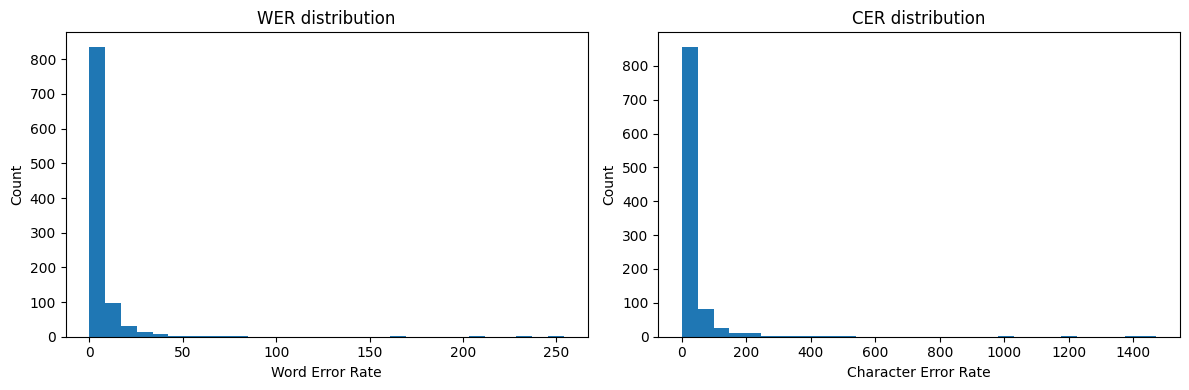

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(df["WER"], bins=30)
plt.title("WER distribution")
plt.xlabel("Word Error Rate")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(df["CER"], bins=30)
plt.title("CER distribution")
plt.xlabel("Character Error Rate")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
import os

EVAL_CSV = "csv_output/evaluation_summary.csv"
os.makedirs(os.path.dirname(EVAL_CSV), exist_ok=True)

df_eval = df[[
    "image_name",
    "CER",
    "WER",
    "gold_text",
    "final_text"
]]

df_eval.to_csv(EVAL_CSV, index=False, encoding="utf-8-sig")
print(f"Saved evaluation summary to {EVAL_CSV}")


Saved evaluation summary to csv_output/evaluation_summary.csv


## Examples


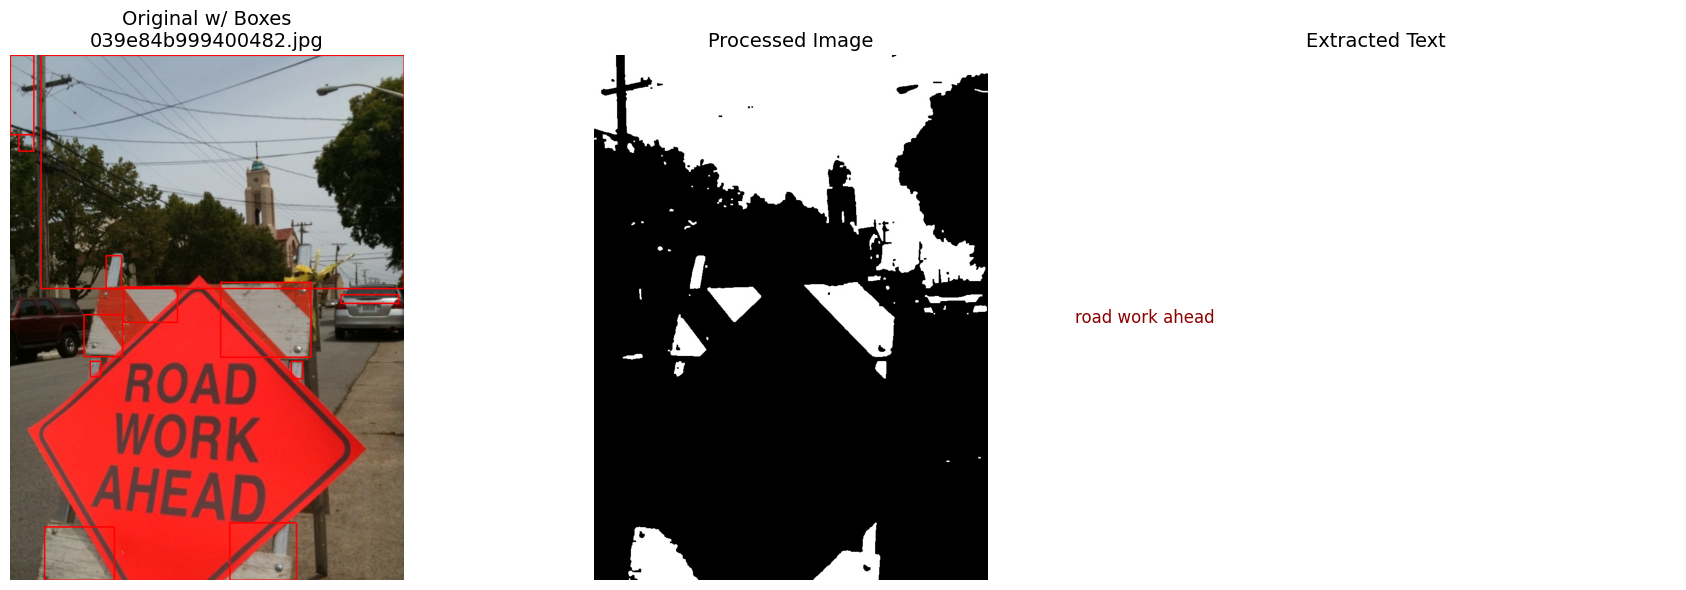

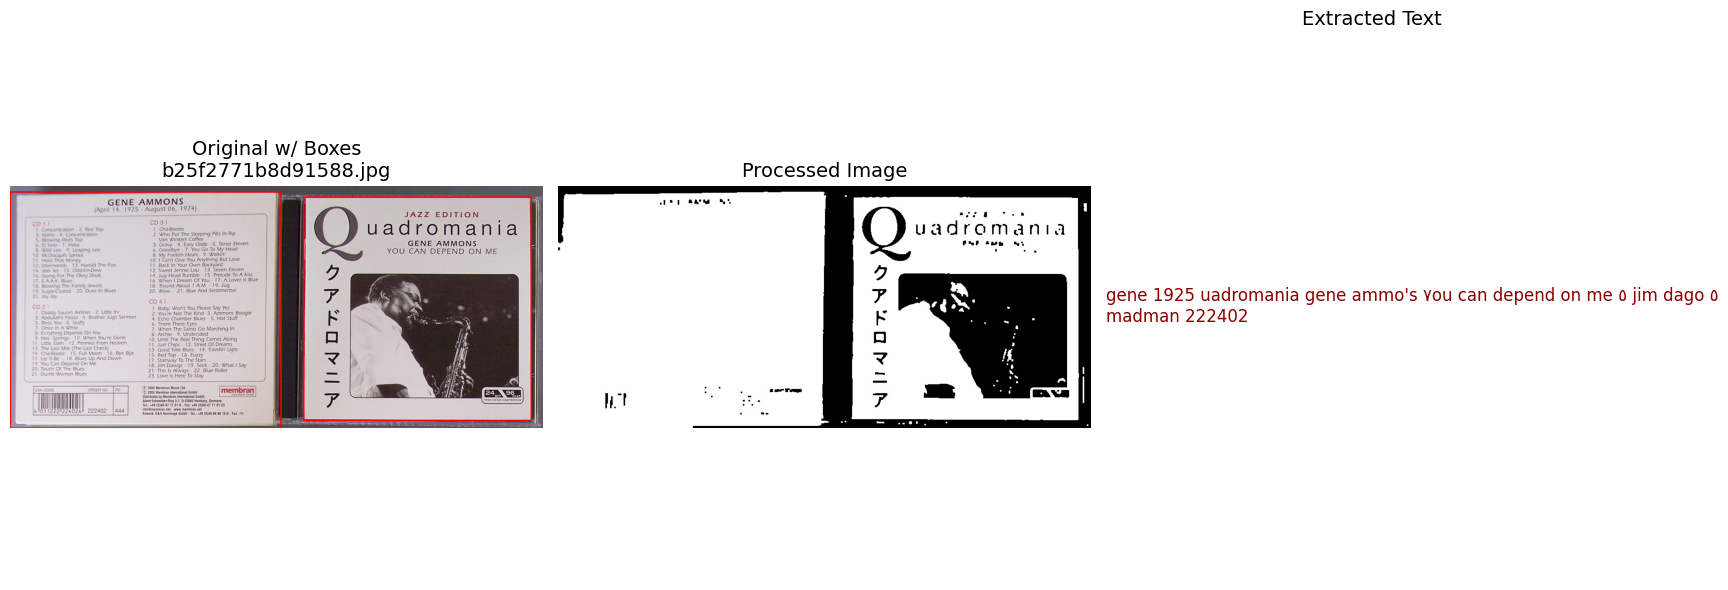

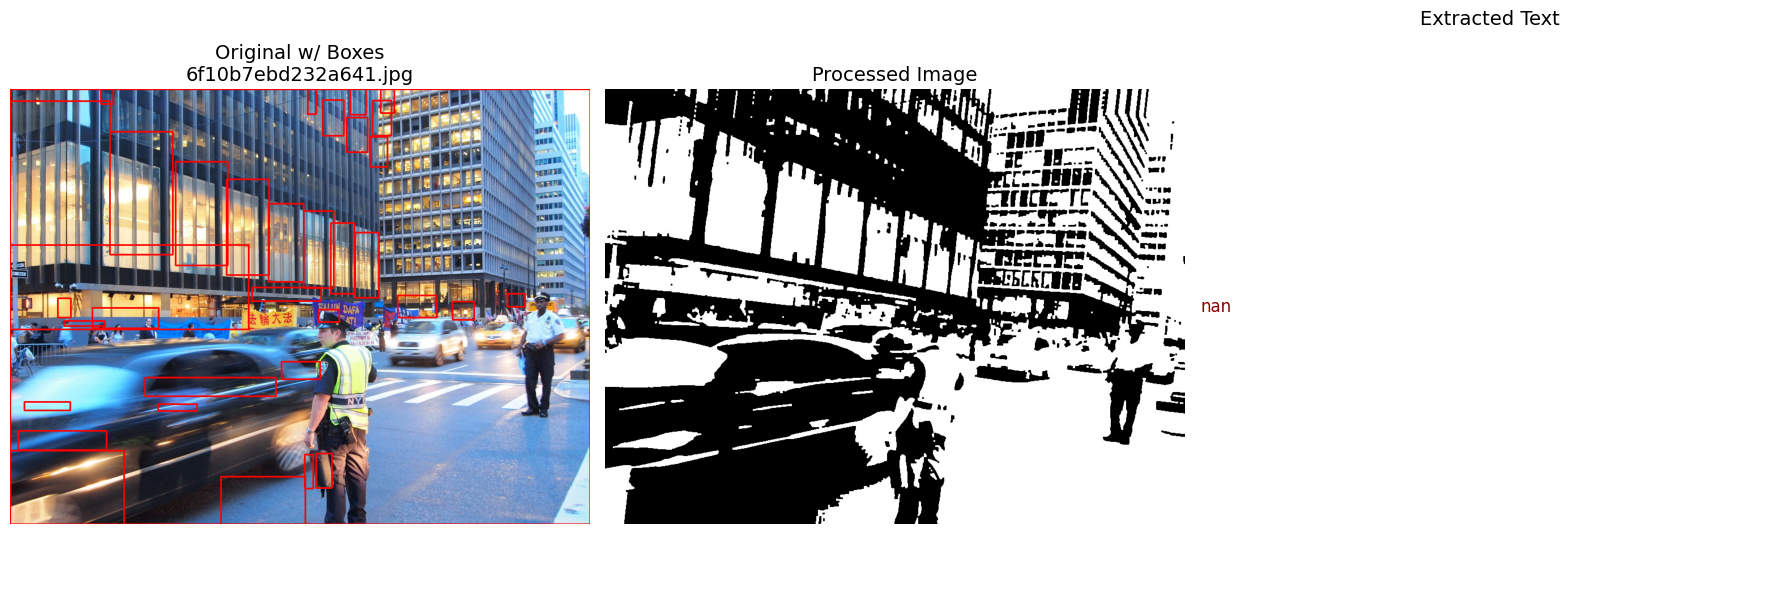

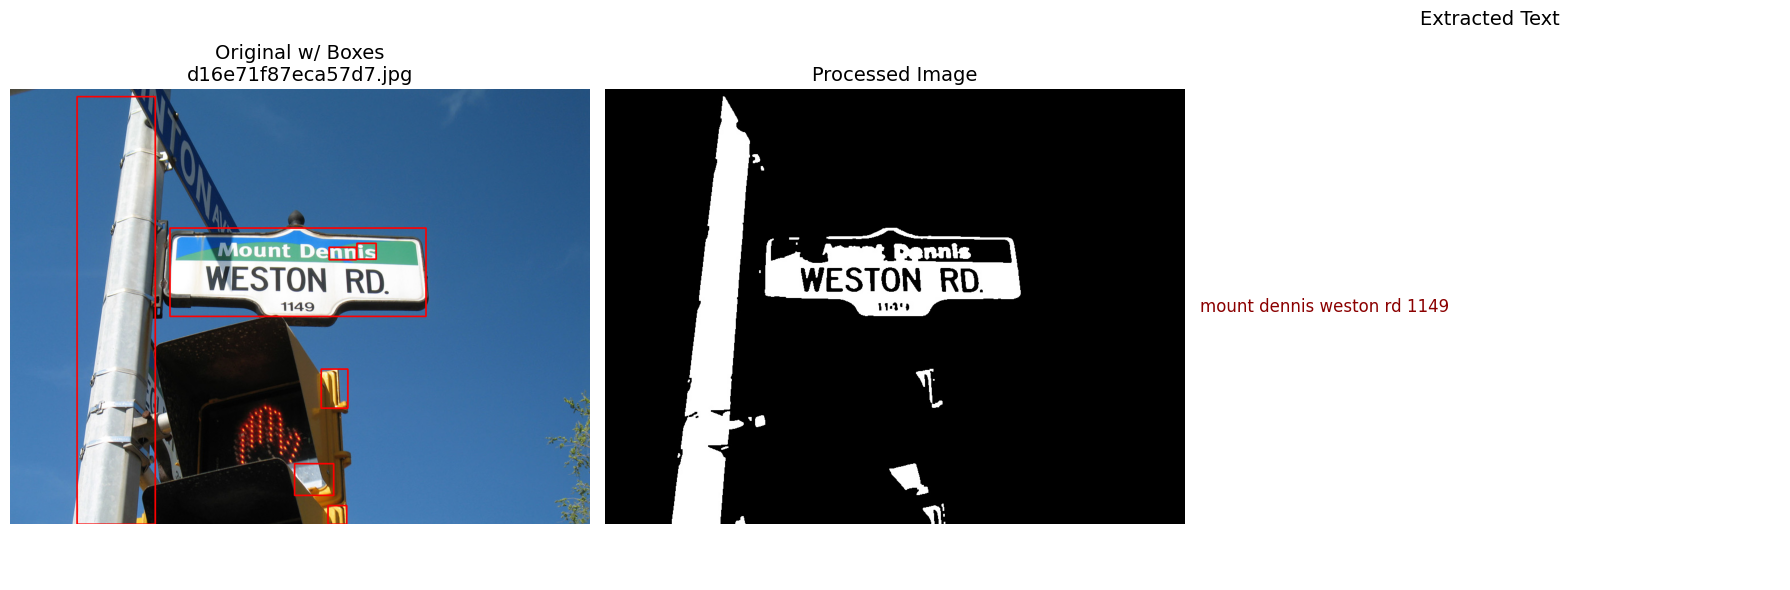

In [147]:
import os
import random
import cv2
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ORIG_DIR      = "data/train_val_images/train_images"
PROC_DIR      = "data/train_val_images_cleaned/train_images"
REGIONS_JSON  = "data/text_regions.json"
EVAL_CSV      = "csv_output/evaluation_summary.csv"

with open(REGIONS_JSON, "r", encoding="utf-8") as f:
    region_map = json.load(f)

df = pd.read_csv(EVAL_CSV, encoding="utf-8-sig")

sample_files = df["image_name"].sample(4, random_state=None).tolist()

for fname in sample_files:
    # Load original RGB image
    orig_bgr = cv2.imread(os.path.join(ORIG_DIR, fname))
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
    # Load processed (cleaned/binarized) image in grayscale
    proc_gray = cv2.imread(os.path.join(PROC_DIR, fname), cv2.IMREAD_GRAYSCALE)
    # Overlay the bounding boxes on a copy of the original
    boxed = orig_rgb.copy()
    for (x, y, w, h) in region_map.get(fname, []):
        cv2.rectangle(boxed, (x, y), (x + w, y + h), (255, 0, 0), 2)
    # Retrieve final, post‐processed OCR text
    ocr_text = df.loc[df["image_name"] == fname, "final_text"].values[0]

    # Create 1×3 subplot: Original w/ boxes, Processed image, Extracted text
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Panel 1: Original with detected regions
    axes[0].imshow(boxed)
    axes[0].set_title(f"Original w/ Boxes\n{fname}", fontsize=14)
    axes[0].axis("off")

    # Panel 2: Processed (cleaned) image
    axes[1].imshow(proc_gray, cmap="gray")
    axes[1].set_title("Processed Image", fontsize=14)
    axes[1].axis("off")

    # Panel 3: Extracted text
    axes[2].text(
        0.0, 0.5,
        ocr_text or "[no OCR text]",
        wrap=True, va="center", ha="left", fontsize=12, color="darkred"
    )
    axes[2].set_title("Extracted Text", fontsize=14)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
